<h2>Лабораторная работа №5 по курсу "Проектирование интеллектуальных систем"</h2>

<p><b>Выполнил:</b> Саврасов П.А. группа ИУ5-24М</p>

<h3>Задание</h3>
<p>На основе приведенного кода нужно выполнить 3 упраженения. Для успешного запуска нужно структурировать код следующим образом:</p>
<ol>
    <li>Генерация данных (процедуры генерации данных приведены в приложении)</li>
    <li>Определение параметров нейросети</li>
    <li>Описание графа вычислений</li>
    <li>Описание функции потерь и оптимизатора</li>
    <li>Обучение и валидация нейронной сети</li>
    <li>Визуализация результатов (динамика ошибки на обучающей и тестовой выборке по итерациям и визуализация предсказаний)</li>
</ol>
<h4>Упражнение 1</h4>
В упражнении 1 имеется 2 временных ряда, которые связаны вместе. Это также можно интерпретировать как двумерный временной ряд. Для выполнения упражнения 1 требуется просто собрать код из приведенных частей и запустить его.
<h4>Упражнение 2</h4>
В упражнении 2 имеется 1 сигнал, который является суперпозицией двух синусоид с разным периодом и смещением. Чтобы получить корректные предсказания, необходимо изменить гиперпараметры нейронной сети.
<h4>Упражнение 3</h4>
Упражнение 3 аналогично упражнению 2, однако входные данные зашумлены. Здесь также нужно
будет настроить гиперпараметры нейронной сети, чтобы получить корректные предсказания.


In [153]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import random
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

<h3>Упражнение 1</h3>
Генератор данных для упражнения 1 (изменённый)

In [479]:
def generate_x_y_data_v1(seq_length):
    batch_x = []
    batch_y = []

    rand = random.random() * 2 * math.pi
    sig1 = np.sin(
        np.linspace(
            0.0 * math.pi + rand,
            3.0 * math.pi + rand, 
            seq_length * 2
        )
    )
    
    sig2 = np.cos(
        np.linspace(0.0 * math.pi + rand,
                    3.0 * math.pi + rand,
                    seq_length * 2
                   )
    )

    x1 = sig1[:seq_length]
    y1 = sig1[seq_length:]
    x2 = sig2[:seq_length]
    y2 = sig2[seq_length:]

    x_ = np.array([x1, x2])
    y_ = np.array([y1, y2])
    x_, y_ = x_.T, y_.T
        
    batch_x.append(x_)
    batch_y.append(y_)
    
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    return batch_x, batch_y

Формат выходных данных x: (10, 1, 2)
Формат выходных данных y: (10, 1, 2)


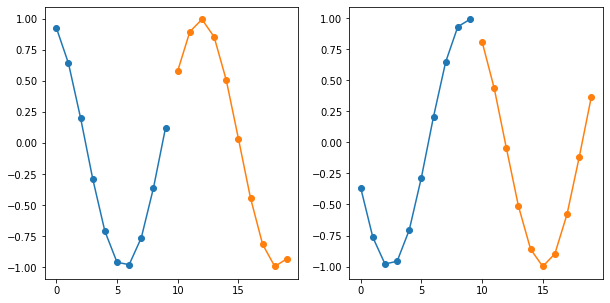

In [552]:
seqLen = 10
xTrain, yTrain = generate_x_y_data_v1(seqLen)
print('Формат выходных данных x:', xTrain.shape)
print('Формат выходных данных y:', yTrain.shape)

plt.subplots(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(seqLen), xTrain.T.reshape((2, seqLen))[0], 'o-')
plt.plot(range(seqLen, seqLen * 2), yTrain.T.reshape((2, seqLen))[0], 'o-')

plt.subplot(1, 2, 2)
plt.plot(range(seqLen), xTrain.T.reshape((2, seqLen))[1], 'o-')
plt.plot(range(seqLen, seqLen*2), yTrain.T.reshape((2, seqLen))[1], 'o-')

In [553]:
model = keras.Sequential()
model.add(layers.GRU(units=200, return_sequences=True, input_shape=(seqLen, 2)))
model.add(layers.GRU(units=100))
model.add(layers.Dense(units=2, activation='tanh'))

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.01),
    loss = keras.losses.MeanAbsoluteError()
)
for i in range(50):
    xTrain, yTrain = generate_x_y_data_v1(seqLen)
    model.fit(xTrain, yTrain, verbose=0)
yPred = model.predict(xTrain)



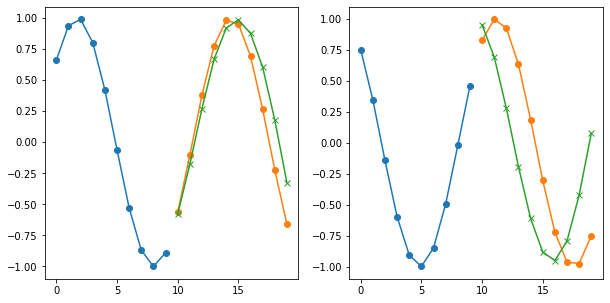

In [569]:
plt.subplots(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(seqLen), xTrain.T.reshape((2, seqLen))[0], 'o-')
plt.plot(range(seqLen, seqLen * 2), yTrain.T.reshape((2, seqLen))[0], 'o-')
plt.plot(range(seqLen, seqLen * 2), yPred.T[0], 'x-')

plt.subplot(1, 2, 2)
plt.plot(range(seqLen), xTrain.T.reshape((2, seqLen))[1], 'o-')
plt.plot(range(seqLen, seqLen * 2), yTrain.T.reshape((2, seqLen))[1], 'o-')
plt.plot(range(seqLen, seqLen * 2), yPred.T[1], 'x-')

<h3>Упражнение 2</h3>
Генератор данных для упражнения 2 (изменённый)

In [494]:
def generate_x_y_data_v2(seq_length):
    batch_x = []
    batch_y = []
    
    offset_rand = random.random() * 2 * math.pi
    freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
    amp_rand = random.random() + 0.1
    sig1 = amp_rand * np.sin(
        np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand,
            seq_length * 2
        )
    )

    offset_rand = random.random() * 2 * math.pi
    freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
    amp_rand = random . random () * 1.2
    sig1 = amp_rand * np.cos(
        np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand,
            seq_length * 2
        )
    ) + sig1

    x1 = sig1[:seq_length]
    y1 = sig1[seq_length:]
    x_ = np.array([x1])
    y_ = np.array([y1])
    x_, y_ = x_.T, y_.T
        
    batch_x.append(x_)
    batch_y.append(y_)
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    return batch_x, batch_y

Формат выходных данных x: (40, 1, 1)
Формат выходных данных y: (40, 1, 1)


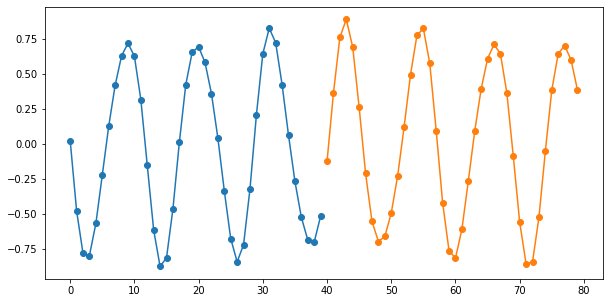

In [578]:
seqLen = 40
x, y = generate_x_y_data_v2(seqLen)
print('Формат выходных данных x:', x.shape)
print('Формат выходных данных y:', y.shape)
x = x.reshape((seqLen))
y = y.reshape((seqLen))

plt.subplots(figsize=(10,5))
plt.plot(range(seqLen), x, 'o-')
plt.plot(range(seqLen, seqLen * 2), y, 'o-')
xTrain, yTrain = generate_x_y_data_v2(seqLen)

In [581]:
model = keras.Sequential()
model.add(layers.GRU(units=200, return_sequences=True, input_shape=(seqLen, 1)))
model.add(layers.GRU(units=100))
model.add(layers.Dense(units=1, activation='tanh'))

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.01),
    loss = keras.losses.MeanAbsoluteError()
)
for i in range(10):
    xTrain, yTrain = generate_x_y_data_v2(seqLen)
    model.fit(xTrain, yTrain, epochs=5, verbose=0)
yPred = model.predict(xTrain)

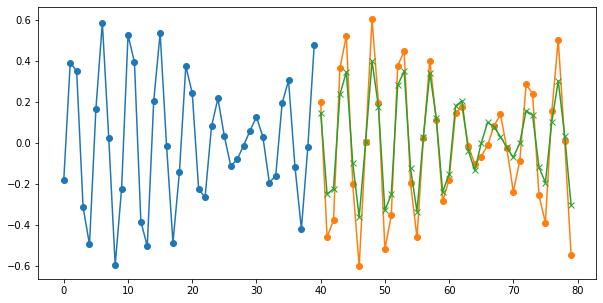

In [583]:
plt.subplots(figsize=(10,5))

plt.plot(range(seqLen), xTrain.T.reshape((1, seqLen))[0], 'o-')
plt.plot(range(seqLen, seqLen * 2), yTrain.reshape(seqLen), 'o-')
plt.plot(range(seqLen, seqLen * 2), yPred, 'x-')

<h3>Упражнение 3</h3>
Генератор данных для упражнения 3 (изменённый)

In [584]:
def generate_x_y_data_v3 (seq_length):
    x, y = generate_x_y_data_v2(seq_length )
    noise_amount = random.random() * 0.15 + 0.10
    x = x + noise_amount * np.random.randn(seq_length, 1, 1)
    avg = np.average(x)
    std = np.std(x) + 0.0001
    x = x - avg
    y = y - avg
    x = x / std / 2.5
    y = y / std / 2.5
    return x, y

Формат выходных данных x: (40, 1, 1)
Формат выходных данных y: (40, 1, 1)


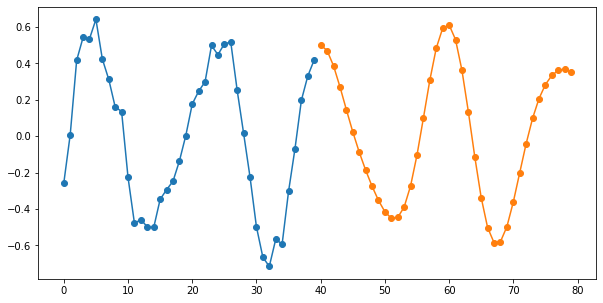

In [589]:
seqLen = 40
x, y = generate_x_y_data_v3(seqLen)
print('Формат выходных данных x:', x.shape)
print('Формат выходных данных y:', y.shape)
x = x.reshape((seqLen))
y = y.reshape((seqLen))

plt.subplots(figsize=(10,5))
plt.plot(range(seqLen), x, 'o-')
plt.plot(range(seqLen, seqLen * 2), y, 'o-')



In [596]:
model = keras.Sequential()
model.add(layers.GRU(units=200, return_sequences=True, input_shape=(seqLen, 1)))
model.add(layers.GRU(units=100))
model.add(layers.Dense(units=1, activation='tanh'))

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.01),
    loss = keras.losses.MeanAbsoluteError()
)
for i in range(10):
    xTrain, yTrain = generate_x_y_data_v2(seqLen)
    model.fit(xTrain, yTrain, epochs=5, verbose=0)
yPred = model.predict(xTrain)

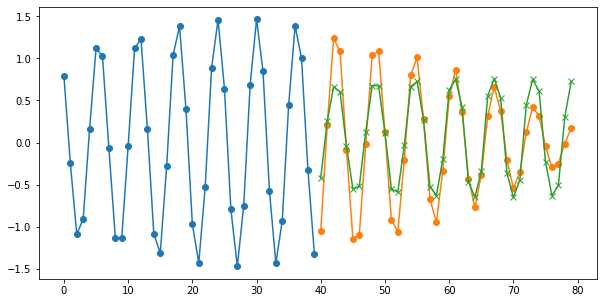

In [597]:
plt.subplots(figsize=(10,5))

plt.plot(range(seqLen), xTrain.T.reshape((1, seqLen))[0], 'o-')
plt.plot(range(seqLen, seqLen * 2), yTrain.reshape(seqLen), 'o-')
plt.plot(range(seqLen, seqLen * 2), yPred, 'x-')